In [74]:
import configparser
import boto3
from datetime import datetime
import os
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear, date_format
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt

### Creating Spark Session

In [2]:
def create_spark_session():
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .getOrCreate()
    return spark

In [3]:
spark = create_spark_session()

### Establish AWS Credentials

In [4]:
config = configparser.ConfigParser()
config.read('dl.cfg')    

['dl.cfg']

In [5]:
os.environ['AWS_ACCESS_KEY_ID']=config.get('AWS','AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY']=config.get('AWS','AWS_SECRET_ACCESS_KEY')
#os.environ['AWS_SESSION_TOKEN']=config.get('AWS','AWS_SESSION_TOKEN')
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

In [6]:
# Set filepath to song and log data files
song_data = "data/song_data/*/*/*/"
log_data = "data/log_data/"

In [7]:
print (song_data)

data/song_data/*/*/*/


In [8]:
# Read files
song_dfs = spark.read.json(song_data)

In [9]:
# Let's check the number of files
song_dfs.count()

71

### Create songs table

In [10]:
songs_table = song_dfs.select(['artist_id','duration','song_id','title','year']).distinct()

In [11]:
songs_table.count()

71

In [12]:
songs_table.show(5)

+------------------+---------+------------------+--------------------+----+
|         artist_id| duration|           song_id|               title|year|
+------------------+---------+------------------+--------------------+----+
|ARGUVEV1187B98BA17|313.12934|SOGOSOV12AF72A285E|   ¿Dónde va Chichi?|1997|
|ARMBR4Y1187B9990EB|241.47546|SOTTDKS12AB018D69B|It Wont Be Christmas|   0|
|ARMAC4T1187FB3FA4C|207.77751|SOBBUGU12A8C13E95D|Setting Fire to S...|2004|
|AR8ZCNI1187B9A069B|269.81832|SOIAZJW12AB01853F1|          Pink World|1984|
|ARDNS031187B9924F0|186.48771|SONYPOM12A8C13B2D7|I Think My Wife I...|2005|
+------------------+---------+------------------+--------------------+----+
only showing top 5 rows



In [13]:
songs_table.createOrReplaceTempView('songs')

### Create artist table

In [14]:
artist_table = song_dfs.select(['artist_id','artist_name','artist_location','artist_latitude','artist_longitude']).distinct()

In [15]:
artist_table.show(5,truncate=False)

+------------------+---------------+---------------+---------------+----------------+
|artist_id         |artist_name    |artist_location|artist_latitude|artist_longitude|
+------------------+---------------+---------------+---------------+----------------+
|AR3JMC51187B9AE49D|Backstreet Boys|Orlando, FL    |28.53823       |-81.37739       |
|AR0IAWL1187B9A96D0|Danilo Perez   |Panama         |8.4177         |-80.11278       |
|ARWB3G61187FB49404|Steve Morse    |Hamilton, Ohio |null           |null            |
|AR47JEX1187B995D81|SUE THOMPSON   |Nevada, MO     |37.83721       |-94.35868       |
|ARHHO3O1187B989413|Bob Azzam      |               |null           |null            |
+------------------+---------------+---------------+---------------+----------------+
only showing top 5 rows



In [16]:
artist_table.createOrReplaceTempView('artist')

### Create log data

In [17]:
print (log_data)

data/log_data/


#### Let's check a log file

In [18]:
log_dfs = spark.read.json(log_data)

In [19]:
log_dfs.count()

8056

In [20]:
log_dfs.show(5)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+---------------+------+-------------+--------------------+------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|           song|status|           ts|           userAgent|userId|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+---------------+------+-------------+--------------------+------+
|   Harmonia|Logged In|     Ryan|     M|            0|   Smith|655.77751| free|San Jose-Sunnyval...|   PUT|NextSong|1.541016707796E12|      583|  Sehr kosmisch|   200|1542241826796|"Mozilla/5.0 (X11...|    26|
|The Prodigy|Logged In|     Ryan|     M|            1|   Smith|260.07465| free|San Jose-Sunnyval...|   PUT|NextSong|1.541016707796E12|      583|The Big Gundown|

In [21]:
### We only get the song plays, page="NextSong"
log_dfs = log_dfs.where('page="NextSong"')

In [22]:
log_dfs = log_dfs.withColumn("songplay_id", monotonically_increasing_id()+1)

In [23]:
log_dfs.show(5)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|                song|status|           ts|           userAgent|userId|songplay_id|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+
|   Harmonia|Logged In|     Ryan|     M|            0|   Smith|655.77751| free|San Jose-Sunnyval...|   PUT|NextSong|1.541016707796E12|      583|       Sehr kosmisch|   200|1542241826796|"Mozilla/5.0 (X11...|    26|          1|
|The Prodigy|Logged In|     Ryan|     M|            1|   Smith|260.07465| free|San Jose-Sunn

In [24]:
artist_table.show(5)

+------------------+---------------+---------------+---------------+----------------+
|         artist_id|    artist_name|artist_location|artist_latitude|artist_longitude|
+------------------+---------------+---------------+---------------+----------------+
|AR3JMC51187B9AE49D|Backstreet Boys|    Orlando, FL|       28.53823|       -81.37739|
|AR0IAWL1187B9A96D0|   Danilo Perez|         Panama|         8.4177|       -80.11278|
|ARWB3G61187FB49404|    Steve Morse| Hamilton, Ohio|           null|            null|
|AR47JEX1187B995D81|   SUE THOMPSON|     Nevada, MO|       37.83721|       -94.35868|
|ARHHO3O1187B989413|      Bob Azzam|               |           null|            null|
+------------------+---------------+---------------+---------------+----------------+
only showing top 5 rows



In [25]:
songs_table.show(5)

+------------------+---------+------------------+--------------------+----+
|         artist_id| duration|           song_id|               title|year|
+------------------+---------+------------------+--------------------+----+
|ARGUVEV1187B98BA17|313.12934|SOGOSOV12AF72A285E|   ¿Dónde va Chichi?|1997|
|ARMBR4Y1187B9990EB|241.47546|SOTTDKS12AB018D69B|It Wont Be Christmas|   0|
|ARMAC4T1187FB3FA4C|207.77751|SOBBUGU12A8C13E95D|Setting Fire to S...|2004|
|AR8ZCNI1187B9A069B|269.81832|SOIAZJW12AB01853F1|          Pink World|1984|
|ARDNS031187B9924F0|186.48771|SONYPOM12A8C13B2D7|I Think My Wife I...|2005|
+------------------+---------+------------------+--------------------+----+
only showing top 5 rows



In [26]:
log_dfs.show(5)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|                song|status|           ts|           userAgent|userId|songplay_id|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+
|   Harmonia|Logged In|     Ryan|     M|            0|   Smith|655.77751| free|San Jose-Sunnyval...|   PUT|NextSong|1.541016707796E12|      583|       Sehr kosmisch|   200|1542241826796|"Mozilla/5.0 (X11...|    26|          1|
|The Prodigy|Logged In|     Ryan|     M|            1|   Smith|260.07465| free|San Jose-Sunn

### Create users table

In [27]:
users_table = log_dfs.select(['userId','firstName','lastName','gender','level']).distinct()

In [28]:
users_table.createOrReplaceTempView('users')

In [29]:
users_table.count()

104

In [30]:
users_table.show(5)

+------+---------+--------+------+-----+
|userId|firstName|lastName|gender|level|
+------+---------+--------+------+-----+
|    57|Katherine|     Gay|     F| free|
|    84|  Shakira|    Hunt|     F| free|
|    22|     Sean|  Wilson|     F| free|
|    52| Theodore|   Smith|     M| free|
|    80|    Tegan|  Levine|     F| paid|
+------+---------+--------+------+-----+
only showing top 5 rows



### Create time table

#### 1. Cast ts field

In [31]:
log_dfs = log_dfs.withColumn('timestamp',(log_dfs.ts.cast('float')/1000).cast("timestamp"))

In [32]:
log_dfs.select("timestamp").show(5,truncate=False)

+-----------------------+
|timestamp              |
+-----------------------+
|2018-11-15 00:29:39.712|
|2018-11-15 00:40:35.072|
|2018-11-15 00:44:57.216|
|2018-11-15 03:44:05.12 |
|2018-11-15 05:48:36.224|
+-----------------------+
only showing top 5 rows



In [33]:
aux = log_dfs.select(['timestamp']).distinct()    

In [34]:
aux.show(5)

+--------------------+
|           timestamp|
+--------------------+
|2018-11-28 06:22:...|
|2018-11-28 12:14:...|
|2018-11-28 17:07:...|
|2018-11-28 20:41:...|
|2018-11-05 18:13:...|
+--------------------+
only showing top 5 rows



In [35]:
log_dfs.show(5)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+--------------------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|                song|status|           ts|           userAgent|userId|songplay_id|           timestamp|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+--------------------+
|   Harmonia|Logged In|     Ryan|     M|            0|   Smith|655.77751| free|San Jose-Sunnyval...|   PUT|NextSong|1.541016707796E12|      583|       Sehr kosmisch|   200|1542241826796|"Mozilla/5.0 (X11...|    26|          1|2018-11-15 00:29:...|
|The Pro

##### 2. Prepare time table 

In [36]:
time_table = log_dfs.select(
    F.col("timestamp").alias("start_time"),    
    F.hour("timestamp").alias("hour"),
    F.minute("timestamp").alias("minute"),
    F.second("timestamp").alias("second"),
    F.dayofmonth("timestamp").alias("day"),
    F.month("timestamp").alias("month"),
    F.year("timestamp").alias("year"),    
    F.dayofweek("timestamp").alias("dayofweek"),
    F.weekofyear("timestamp").alias("week"),
    F.date_format(F.col("timestamp"),"E").alias("weekday")     
    )

In [37]:
time_table.show(5,False)

+-----------------------+----+------+------+---+-----+----+---------+----+-------+
|start_time             |hour|minute|second|day|month|year|dayofweek|week|weekday|
+-----------------------+----+------+------+---+-----+----+---------+----+-------+
|2018-11-15 00:29:39.712|0   |29    |39    |15 |11   |2018|5        |46  |Thu    |
|2018-11-15 00:40:35.072|0   |40    |35    |15 |11   |2018|5        |46  |Thu    |
|2018-11-15 00:44:57.216|0   |44    |57    |15 |11   |2018|5        |46  |Thu    |
|2018-11-15 03:44:05.12 |3   |44    |5     |15 |11   |2018|5        |46  |Thu    |
|2018-11-15 05:48:36.224|5   |48    |36    |15 |11   |2018|5        |46  |Thu    |
+-----------------------+----+------+------+---+-----+----+---------+----+-------+
only showing top 5 rows



In [38]:
time_table = time_table.sort("start_time")

In [39]:
time_table.show(5,False)

+-----------------------+----+------+------+---+-----+----+---------+----+-------+
|start_time             |hour|minute|second|day|month|year|dayofweek|week|weekday|
+-----------------------+----+------+------+---+-----+----+---------+----+-------+
|2018-11-01 21:02:51.904|21  |2     |51    |1  |11   |2018|5        |44  |Thu    |
|2018-11-01 21:05:02.976|21  |5     |2     |1  |11   |2018|5        |44  |Thu    |
|2018-11-01 21:07:14.048|21  |7     |14    |1  |11   |2018|5        |44  |Thu    |
|2018-11-01 21:11:36.192|21  |11    |36    |1  |11   |2018|5        |44  |Thu    |
|2018-11-01 21:18:09.408|21  |18    |9     |1  |11   |2018|5        |44  |Thu    |
+-----------------------+----+------+------+---+-----+----+---------+----+-------+
only showing top 5 rows



In [40]:
time_table = time_table.drop_duplicates(subset=['start_time'])

In [41]:
output_data='output/'

In [42]:
#time_table.write.parquet(os.path.join(output_data, 'timetable'), partitionBy=['year', 'month'])

In [43]:
time_table.createOrReplaceTempView('timetable')

In [44]:
song_dfs.show(2,False)

+------------------+---------------+---------------+----------------+----------------------------------------------------------------------------------------------+---------+---------+------------------+-------------------------------+----+
|artist_id         |artist_latitude|artist_location|artist_longitude|artist_name                                                                                   |duration |num_songs|song_id           |title                          |year|
+------------------+---------------+---------------+----------------+----------------------------------------------------------------------------------------------+---------+---------+------------------+-------------------------------+----+
|ARDR4AC1187FB371A1|null           |               |null            |Montserrat Caballé;Placido Domingo;Vicente Sardinero;Judith Blegen;Sherrill Milnes;Georg Solti|511.16363|1        |SOBAYLL12A8C138AF9|Sono andati? Fingevo di dormire|0   |
|AREBBGV1187FB523D2|null           |

In [45]:
log_dfs.show(1,False)

+--------+---------+---------+------+-------------+--------+---------+-----+----------------------------------+------+--------+-----------------+---------+-------------+------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------+------+-----------+-----------------------+
|artist  |auth     |firstName|gender|itemInSession|lastName|length   |level|location                          |method|page    |registration     |sessionId|song         |status|ts           |userAgent                                                                                                                                |userId|songplay_id|timestamp              |
+--------+---------+---------+------+-------------+--------+---------+-----+----------------------------------+------+--------+-----------------+---------+-------------+------+-------------+------------------------------------------------------------------

In [46]:
log_dfs.createOrReplaceTempView("logs")

### Create song play table

In [47]:
songplays_table = spark.sql("""
        SELECT l.songplay_id,
        l.ts AS start_time, 
        l.userId AS user_id,
        l.level,
        s.song_id,
        s.artist_id, 
        l.sessionId AS session_id,
        l.location,
        l.userAgent AS user_agent,
        t.month,
        t.year
        FROM logs l 
        JOIN songs s ON s.title=l.song
        JOIN timetable t ON l.timestamp=t.start_time
        """).dropDuplicates()

In [48]:
songplays_table.count()

4

In [49]:
songplays_table = spark.sql("""
        SELECT l.songplay_id,
        l.ts AS start_time, 
        l.userId AS user_id,
        l.level,
        s.song_id,
        s.artist_id, 
        l.sessionId AS session_id,
        l.location,
        l.userAgent AS user_agent,
        t.month,
        t.year
        FROM logs l 
        JOIN songs s ON s.title=l.song
        JOIN timetable t ON l.timestamp=t.start_time
        """)

In [50]:
songplays_table.count()

4

In [51]:
songplays_table.show(5)

+-----------+-------------+-------+-----+------------------+------------------+----------+--------------------+--------------------+-----+----+
|songplay_id|   start_time|user_id|level|           song_id|         artist_id|session_id|            location|          user_agent|month|year|
+-----------+-------------+-------+-----+------------------+------------------+----------+--------------------+--------------------+-----+----+
|        883|1542837407796|     15| paid|SOZCTXZ12AB0182364|AR5KOSW1187FB35FF4|       818|Chicago-Napervill...|"Mozilla/5.0 (X11...|   11|2018|
| 8589934643|1542171963796|     10| free|SOGDBUF12A8C140FAA|AR558FS1187FB45658|       484|Washington-Arling...|"Mozilla/5.0 (Mac...|   11|2018|
|42949673401|1542618860796|     24| paid|SOGDBUF12A8C140FAA|AR558FS1187FB45658|       672|Lake Havasu City-...|"Mozilla/5.0 (Win...|   11|2018|
|51539607782|1543358159796|     80| paid|SOGDBUF12A8C140FAA|AR558FS1187FB45658|       992|Portland-South Po...|"Mozilla/5.0 (Mac...|   1

In [52]:
songplays_table.count()

4

In [53]:
songplays_table.createOrReplaceTempView("songplays")

In [54]:
users_table = log_dfs.select(['userId','firstName','lastName','gender','level']).distinct()

### Write info to parquet files

In [55]:
output_data= "./output/"

In [57]:
songs_table.write.partitionBy(['year','artist_id']).parquet(output_data + 'songs/' + 'songs.parquet','overwrite')
artist_table.write.parquet(output_data + 'artists/' + 'artists.parquet','overwrite')
users_table.write.parquet(output_data + 'users/' + 'users.parquet','overwrite')
songplays_table.write.partitionBy(['year','month']).parquet(output_data + 'songplays/' + 'songsplays.parquet','overwrite')
time_table.write.partitionBy(['year','month']).parquet(output_data + 'timetable/' + 'timetable.parquet','overwrite')

### MINI EDA

In [58]:
# Let's see the types in the song_dfs dataset
song_dfs.describe()

DataFrame[summary: string, artist_id: string, artist_latitude: string, artist_location: string, artist_longitude: string, artist_name: string, duration: string, num_songs: string, song_id: string, title: string, year: string]

In [59]:
# Let's see the types in the log_dfs dataset
log_dfs.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, songplay_id: string]

### SKEWNESS


In [60]:
song_dfs.groupBy(F.spark_partition_id()).count().show()

+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                  12|    5|
|                   1|    5|
|                  13|    5|
|                   6|    5|
|                   3|    5|
|                   5|    5|
|                   9|    5|
|                   4|    5|
|                   8|    5|
|                   7|    5|
|                  10|    5|
|                  11|    5|
|                  14|    1|
|                   2|    5|
|                   0|    5|
+--------------------+-----+



### We can see with song_dfs dataset exhibits no skew — all row counts are identical in every partition, except in one partition. Good! Now let's see if I want to see the data in each partition...

In [61]:
song_dfs.rdd.glom().collect()

[[Row(artist_id='ARDR4AC1187FB371A1', artist_latitude=None, artist_location='', artist_longitude=None, artist_name='Montserrat Caballé;Placido Domingo;Vicente Sardinero;Judith Blegen;Sherrill Milnes;Georg Solti', duration=511.16363, num_songs=1, song_id='SOBAYLL12A8C138AF9', title='Sono andati? Fingevo di dormire', year=0),
  Row(artist_id='AREBBGV1187FB523D2', artist_latitude=None, artist_location='Houston, TX', artist_longitude=None, artist_name="Mike Jones (Featuring CJ_ Mello & Lil' Bran)", duration=173.66159, num_songs=1, song_id='SOOLYAZ12A6701F4A6', title='Laws Patrolling (Album Version)', year=0),
  Row(artist_id='ARMAC4T1187FB3FA4C', artist_latitude=40.82624, artist_location='Morris Plains, NJ', artist_longitude=-74.47995, artist_name='The Dillinger Escape Plan', duration=207.77751, num_songs=1, song_id='SOBBUGU12A8C13E95D', title='Setting Fire to Sleeping Giants', year=2004),
  Row(artist_id='ARPBNLO1187FB3D52F', artist_latitude=40.71455, artist_location='New York, NY', artis

### We can see with log_dfs dataset exhibits big skew — all row counts are different in every partition.
### Here we can apply two methods:
#### 1. Do a repartition by a certain column, like the ones we are using for the groupby selections or
#### 2. Do a random repartition or salt, this is useful when we don't know how to do the repartition

In [65]:
log_dfs.groupBy(F.spark_partition_id()).count().show()

+--------------------+-----+
|SPARK_PARTITION_ID()|count|
+--------------------+-----+
|                  12|  182|
|                   1|  753|
|                  13|  160|
|                   6|  495|
|                   3|  649|
|                   5|  595|
|                   9|  318|
|                   4|  636|
|                   8|  327|
|                   7|  468|
|                  10|  309|
|                  11|  265|
|                  14|   52|
|                   2|  695|
|                   0|  916|
+--------------------+-----+



In [66]:
log_dfs.rdd.glom().collect()

[[Row(artist='Harmonia', auth='Logged In', firstName='Ryan', gender='M', itemInSession=0, lastName='Smith', length=655.77751, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='Sehr kosmisch', status=200, ts=1542241826796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"', userId='26', songplay_id=1, timestamp=datetime.datetime(2018, 11, 15, 0, 29, 39, 712000)),
  Row(artist='The Prodigy', auth='Logged In', firstName='Ryan', gender='M', itemInSession=1, lastName='Smith', length=260.07465, level='free', location='San Jose-Sunnyvale-Santa Clara, CA', method='PUT', page='NextSong', registration=1541016707796.0, sessionId=583, song='The Big Gundown', status=200, ts=1542242481796, userAgent='"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.

### QUERIES

### Let's see how many users have free/paid accounts

In [67]:
# users with free level
users_by_level = spark.sql("""    
        SELECT level, count(*) as NumberOfUsers
        FROM users
        GROUP BY level        
        """)

In [68]:
users_by_level.show()
# We can see 82 users have free accounts and 22 users have paid accounts

+-----+-------------+
|level|NumberOfUsers|
+-----+-------------+
| free|           82|
| paid|           22|
+-----+-------------+



In [69]:
# users with free level
users_by_gender = spark.sql("""    
        SELECT gender, count(*) as NumberOfUsers
        FROM users
        GROUP BY gender        
        """)

In [70]:
users_by_gender.show()
# We can see a majority of the users are women

+------+-------------+
|gender|NumberOfUsers|
+------+-------------+
|     F|           60|
|     M|           44|
+------+-------------+



In [75]:
# Let's define some functions to visualize data
# These are from https://github.com/roshankoirala/pySpark_tutorial
def pieplot(df, col, lim=10, yname=None):
    
    '''
    This function makes a pie chart for the Spark dataframe df 
    for categorical column col only selecting top categories 
    as specified by lim. 
    '''
    
    # Grouping by the categories, counting on each categories 
    # and ordering them by the count
    classes = c.orderBy('count', ascending=False)
    
    # Take first 'lim' number of rows and convert to pandas  
    pd_df = classes.limit(lim).toPandas()
    
    # Making plot 
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()
    
def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()             

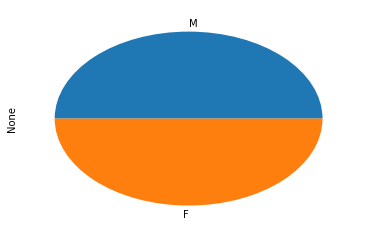

In [76]:
pieplot(users_by_gender, 'Gender')

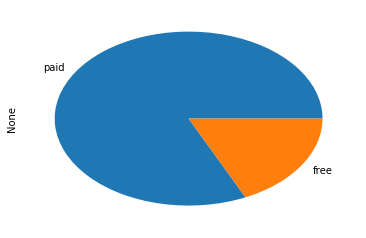

In [77]:
pieplot(log_dfs, 'level')

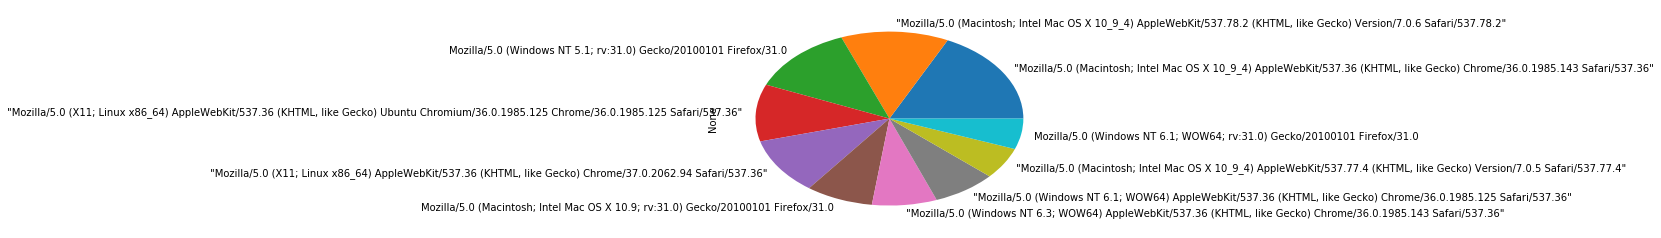

In [78]:
pieplot(log_dfs, 'userAgent')

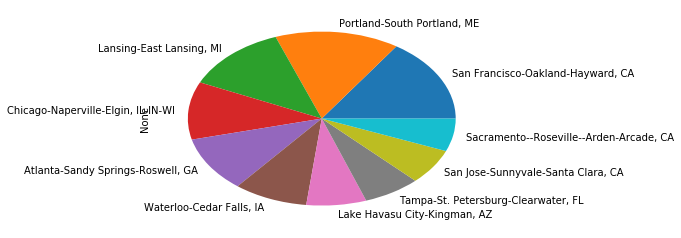

In [79]:
pieplot(log_dfs, 'location')

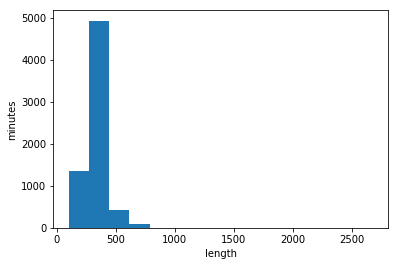

In [80]:
# Plotting an histogram 
histogram(log_dfs, 'length', bins=15, yname='minutes')

In [121]:
log_dfs.show(5)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+--------------------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|                song|status|           ts|           userAgent|userId|songplay_id|           timestamp|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------------+------+-------------+--------------------+------+-----------+--------------------+
|   Harmonia|Logged In|     Ryan|     M|            0|   Smith|655.77751| free|San Jose-Sunnyval...|   PUT|NextSong|1.541016707796E12|      583|       Sehr kosmisch|   200|1542241826796|"Mozilla/5.0 (X11...|    26|          1|2018-11-15 00:29:...|
|The Pro

In [82]:
TOP_10_listerers = spark.sql("""    
        SELECT user_id, COUNT(*) AS count
        FROM songplays
        GROUP BY user_id
        ORDER BY count DESC
        LIMIT 5    
        """)

In [83]:
TOP_10_listerers.show()

+-------+-----+
|user_id|count|
+-------+-----+
|     15|    1|
|     24|    1|
|     10|    1|
|     80|    1|
+-------+-----+



### Write Data on S3

In [100]:
bucket_folder='my-udacity-sparkify-data-lake'

In [101]:
session = boto3.Session(
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    #aws_session_token=os.environ["AWS_SESSION_TOKEN"],
)
s3 = session.resource('s3', region_name='us-east-1')

In [102]:
try:
        s3.create_bucket(ACL='private',Bucket=bucket_folder)
except Exception as e:
        if 'BucketAlreadyOwnedByYou' in str(e):
            print(f'{bucket_folder} already exists')
        else:
            raise e